In [23]:
import torch
import cv2

In [24]:
img_path = '/root/lanyun-tmp/openmmlab/mmdetection/demo/demo.jpg'
model_config_path = '/root/lanyun-tmp/openmmlab/mmdetection/configs/yolo/yolov3_mobilenetv2_8xb24-ms-416-300e_coco.py'
model_pth_path = '/root/lanyun-tmp/openmmlab/mmdetection/checkpoints/yolov3_mobilenetv2_mstrain-416_300e_coco_20210718_010823-f68a07b3.pth'

In [25]:
from mmdet.apis import init_detector, inference_detector
import mmcv


# 初始化检测模型
model = init_detector(model_config_path, model_pth_path, device='cuda:0')


Loads checkpoint by local backend from path: /root/lanyun-tmp/openmmlab/mmdetection/checkpoints/yolov3_mobilenetv2_mstrain-416_300e_coco_20210718_010823-f68a07b3.pth


In [26]:
model

YOLOV3(
  (data_preprocessor): DetDataPreprocessor()
  (backbone): MobileNetV2(
    (conv1): ConvModule(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activate): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (layer1): Sequential(
      (0): InvertedResidual(
        (drop_path): Identity()
        (depthwise_conv): ConvModule(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activate): LeakyReLU(negative_slope=0.1, inplace=True)
        )
        (linear_conv): ConvModule(
          (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (

In [27]:
import cv2
import numpy as np
import torch

def preprocess_image(img_path, img_size=416):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0  # 归一化
    img = np.transpose(img, (2, 0, 1))  # HWC to CHW
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = torch.from_numpy(img).float()
    return img


In [28]:
input_tensor = preprocess_image(img_path)

In [29]:
input_tensor.shape

torch.Size([1, 3, 416, 416])

In [30]:
def predict(model, img_tensor, device='cuda'):
    model = model.to(device)
    img_tensor = img_tensor.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
    return outputs


In [31]:
outputs = predict(model=model, img_tensor=input_tensor)

In [32]:
outputs

((tensor([[[[ 1.0465e+00,  4.5065e-02, -1.3630e-01,  ...,  1.9269e-02,
             -6.5033e-02,  3.8888e-01],
            [ 1.7894e+00, -1.8969e-01, -3.3063e-01,  ..., -6.4247e-02,
             -3.4014e-02,  3.7345e-01],
            [ 2.2822e+00,  1.2899e-02, -2.7935e-01,  ...,  1.6850e-03,
              1.6935e-01,  4.9029e-01],
            ...,
            [ 2.1165e+00,  4.2137e-01, -2.1424e-01,  ...,  6.5367e-01,
              2.3249e-01,  5.2321e-02],
            [ 2.0089e+00,  7.4207e-01,  8.9423e-02,  ..., -2.9381e-01,
              7.4267e-01, -5.0151e-01],
            [ 1.2716e+00,  5.9830e-01,  4.5069e-01,  ..., -9.7000e-01,
              1.1999e+00, -4.4332e-01]],
  
           [[ 8.5715e-01,  1.0286e+00,  9.2498e-01,  ...,  4.8961e-01,
              5.6426e-01,  4.5479e-01],
            [ 4.1574e-01,  5.6934e-01,  5.5863e-01,  ...,  5.3959e-01,
              5.8828e-01,  5.9948e-01],
            [ 3.3799e-01,  5.0749e-01,  6.8245e-01,  ...,  4.3774e-01,
              5.0260

In [33]:
len(outputs[0])

3

In [34]:
out1, out2, out3 = outputs[0][0], outputs[0][1], outputs[0][2]

In [35]:
out1.shape

torch.Size([1, 255, 13, 13])

In [36]:
out2.shape

torch.Size([1, 255, 26, 26])

In [37]:
out3.shape

torch.Size([1, 255, 52, 52])

In [38]:
import torch

def sigmoid(x):
    return torch.sigmoid(x)

def xywh2xyxy(x):
    # Convert bounding box format from (x_center, y_center, width, height) to (x1, y1, x2, y2)
    y = x.clone()
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y

def non_max_suppression(prediction, conf_thres=0.5, iou_thres=0.4):
    """
    Runs Non-Maximum Suppression (NMS) on inference results
    :param prediction: [array] shape [N, 5 + num_classes] where N is the number of boxes
    :param conf_thres: [float] object confidence threshold
    :param iou_thres: [float] IOU threshold for NMS
    :return: (x1, y1, x2, y2, object_conf, class_conf, class)
    """
    # Convert from center-wh format to corner-xy format
    boxes = xywh2xyxy(prediction[..., :4])
    conf = prediction[..., 4]
    class_conf, class_pred = torch.max(prediction[..., 5:], dim=-1, keepdim=True)

    # Filter out low confidence scores
    mask = conf > conf_thres
    boxes, conf, class_conf, class_pred = boxes[mask], conf[mask], class_conf[mask], class_pred[mask]

    # Merge boxes, scores, and classes
    detections = torch.cat((boxes, conf.unsqueeze(1), class_conf, class_pred.float()), dim=1)
    
    unique_classes = torch.unique(class_pred)
    best_boxes = []
    for c in unique_classes:
        # Perform NMS per class
        # class_mask = (class_pred == c)
        class_mask = (class_pred == c).squeeze()  # 确保class_mask是1维的
        class_boxes = detections[class_mask]
        while class_boxes.shape[0]:
            # Get box with highest confidence
            max_index = torch.argmax(class_boxes[:, 4])
            best_box = class_boxes[max_index]
            best_boxes.append(best_box)
            if len(class_boxes) == 1:
                break
            # Compute IoU and remove boxes with IoU > threshold
            class_boxes = torch.cat((class_boxes[:max_index], class_boxes[max_index+1:]), dim=0)
            ious = bbox_iou(best_box[:4], class_boxes[:, :4])
            class_boxes = class_boxes[ious < iou_thres]
    return torch.stack(best_boxes) if len(best_boxes) > 0 else torch.tensor([])

def bbox_iou(box1, box2, x1y1x2y2=True):
    """
    Return intersection-over-union (IoU) between box1 and box2
    """
    if not x1y1x2y2:
        # Transform from xywh to xyxy
        box1 = xywh2xyxy(box1)
        box2 = xywh2xyxy(box2)

    # Get the coordinates of bounding boxes
    b1_x1, b1_y1, b1_x2, b1_y2 = box1.T
    b2_x1, b2_y1, b2_x2, b2_y2 = box2.T

    # Intersection area
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    inter_area = torch.clip(inter_rect_x2 - inter_rect_x1, min=0) * torch.clip(inter_rect_y2 - inter_rect_y1, min=0)
    
    # Union Area
    b1_area = (b1_x2 - b1_x1) * (b1_y2 - b1_y1)
    b2_area = (b2_x2 - b2_x1) * (b2_y2 - b2_y1)

    iou = inter_area / (b1_area + b2_area - inter_area)
    return iou

def process_yolo_output(output, anchors, num_classes, img_size, conf_thres, iou_thres):
    """
    Process output of YOLO model.
    :param output: output of the model
    :param anchors: anchors used in YOLO model
    :param num_classes: number of classes
    :param img_size: size of the input image
    :param conf_thres: confidence threshold
    :param iou_thres: IoU threshold for NMS
    :return: filtered bounding boxes
    """
    grid_size = output.shape[2]
    stride = img_size / grid_size
    bbox_attrs = 5 + num_classes
    num_anchors = len(anchors)

    # Reshape to [batch, num_anchors, grid_size, grid_size, bbox_attrs]
    prediction = output.view(1, num_anchors, bbox_attrs, grid_size, grid_size).permute(0, 1, 3, 4, 2).contiguous()
    
    # Sigmoid the center_x, center_y, and object confidence
    x = sigmoid(prediction[..., 0])  # Center x
    y = sigmoid(prediction[..., 1])  # Center y
    w = prediction[..., 2]  # Width
    h = prediction[..., 3]  # Height
    conf = sigmoid(prediction[..., 4])  # Conf
    pred_cls = sigmoid(prediction[..., 5:])  # Cls pred.
    
    # Calculate offsets for each grid
    grid_x = torch.arange(grid_size).repeat(grid_size, 1).view([1, 1, grid_size, grid_size]).float().to(output.device)
    grid_y = grid_x.permute(0, 1, 3, 2)
    
    # Add offset and scale with anchors
    anchors = anchors.view(num_anchors, 1, 1, 2).to(prediction.device)
    pred_boxes = torch.zeros(prediction[..., :4].shape).to(prediction.device)
    pred_boxes[..., 0] = x + grid_x
    pred_boxes[..., 1] = y + grid_y
    pred_boxes[..., 2] = torch.exp(w) * anchors[:, :, :, 0]
    pred_boxes[..., 3] = torch.exp(h) * anchors[:, :, :, 1]

    # Resize to image size
    pred_boxes[..., :4] *= stride

    # Reshape for filtering
    pred_boxes = pred_boxes.view(-1, 4)
    conf = conf.view(-1, 1)
    pred_cls = pred_cls.view(-1, num_classes)

    # Filter out confidence scores below threshold
    mask = conf > conf_thres
    pred_boxes = pred_boxes[mask.squeeze()]
    conf = conf[mask].view(-1, 1)  # 确保conf的形状是正确的  调整形状为(N, 1)
    pred_cls = pred_cls[mask.squeeze()]  

    output = torch.cat((pred_boxes, conf, pred_cls), 1)

    # NMS
    boxes = non_max_suppression(output, conf_thres, iou_thres)
    return boxes

# Example usage
anchors1 = torch.tensor([(116, 90), (156, 198), (373, 326)])
anchors2 = torch.tensor([(30, 61), (62, 45), (59, 119)])
anchors3 = torch.tensor([(10, 13), (16, 30), (33, 23)])
num_classes = 80
img_size = 416
conf_thres = 0.5
iou_thres = 0.4

# 假设你已经有了输出结果
outputs = [out1, out2, out3]

# 为每个输出指定正确的anchors
boxes1 = process_yolo_output(outputs[0], anchors1, num_classes, img_size, conf_thres, iou_thres)
boxes2 = process_yolo_output(outputs[1], anchors2, num_classes, img_size, conf_thres, iou_thres)
boxes3 = process_yolo_output(outputs[2], anchors3, num_classes, img_size, conf_thres, iou_thres)

# 合并所有尺度的boxes
boxes = torch.cat((boxes1, boxes2, boxes3), dim=0)


In [39]:
import cv2

img = cv2.imread(img_path)

In [44]:
def draw_boxes(img, boxes, class_names):
    for box in boxes:
        # x1, y1, x2, y2 = box[:4].int()
        x1, y1, x2, y2 = map(int, box[:4])  # 将坐标值转换为整数类型
        conf = box[4].item()
        cls_conf = box[5].item()
        cls_pred = int(box[6].item())

        # 绘制边界框
        color = (0, 255, 0)  # Green
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

        # 绘制标签
        label = f'{class_names[cls_pred]}: {cls_conf:.2f}'
        cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return img

In [45]:
# 假设class_names是一个包含类别名称的列表
class_names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train',
         'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
         'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep',
         'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella',
         'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
         'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
         'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork',
         'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
         'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair',
         'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv',
         'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
         'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
         'scissors', 'teddy bear', 'hair drier', 'toothbrush']  # 根据实际情况填写类别名称

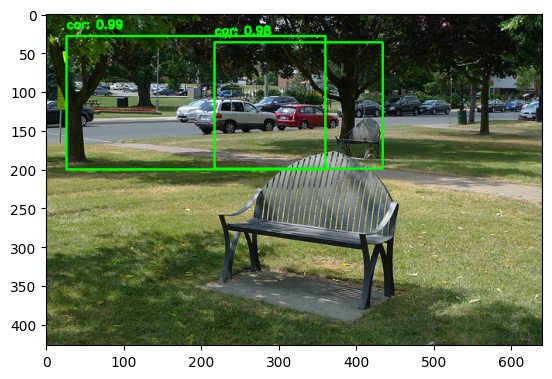

In [46]:
import matplotlib.pyplot as plt
img = draw_boxes(img, boxes, class_names=class_names)
plt.imshow(img[:,:,::-1])
plt.show()
